# TransientAsciiSEDMetric

This is a notebook to demonstrate the TransientAsciiSEDMetric. This is very similar to TransientAsciiMetric and it's uses are nearly identical. See that notebook along with the code for both metrics for further descriptions of their functionality.

In case the user's environment does not have the following necessary packages, please run this line; otherwise skip.

In [1]:
!pip install sncosmo sympy

You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Imports

In [2]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from maf_local.GW170817DetMetric import GW170817DetMetric as kNeMAF

## To demonstrate we will use a wrapper metric for transientAsciiSEDMetric based on GW170817 for a kilonova.

In [3]:
# Set the database and query
runName = 'kraken2026'
#This next command assumes you have downloaded kraken_2026.db into the tutorials directory in this repo.
#Change this path according to your datbase and where it is saved.
opsdb = db.OpsimDatabase('kraken_2026.db')

In [4]:
# Set the output directory
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir)

In [5]:
# Setup the metric
asciiSED = 'DECAMGemini_SED.txt'
# output_data = True will return lightcurves rather than summary values
transMetric = kNeMAF(asciiSED, mjdCol='observationStartMJD', output_data=True, num_phases_to_run = 1)

### Use the metric to output observations of lightcurves

In [6]:
# Use the metric to generate a tightly sampled lightcurve, to illustrate what the lightcurve looks like.
filterNames = ['u', 'g', 'r', 'i', 'z', 'y']
times = np.arange(0, transMetric.transient_duration, 0.25)
lc = {}
for f in filterNames:
    transMetric.make_lightcurve(times, np.array([f]*len(times)))
    lc[f] = transMetric.light_curve_mags

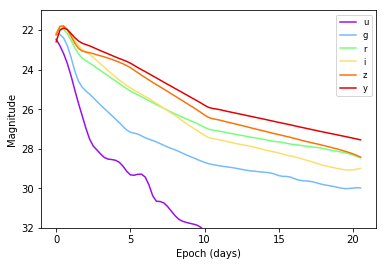

In [7]:
# Plot the light curves
colors =  {'u':'#9a0eea','g':'#75bbfd','r':'#76ff7b','i':'#fdde6c','z':'#f97306','y':'#e50000'}
plt.figure()
for f in filterNames:
    plt.plot(times, lc[f], color=colors[f], label=f)
plt.ylim(32, 21)
plt.xlabel('Epoch (days)')
plt.ylabel('Magnitude')
plt.legend(fontsize='smaller', numpoints=1)

### Now do this for observations made given a pointing slicer

In [8]:
# With the UserPointsSlicer, you can set ra/dec for the places you want to evaluate.
# These ra/dec pairs are 1 DD field and 3 WFD fields.
ra = np.array([ 34.39339593,  73.58279239,  97.45622484,  94.92638699])
dec = np.array([ -5.09032894,   0.1873572 , -37.70921729, -18.53667436])
slicer = slicers.UserPointsSlicer(ra, dec)

In [9]:
# SQL constraint.
# select the of the survey that you want to run 
year = 9.5
sqlconstraint = 'night between %f and %f'% ((365.25*year,365.25*(year+0.5)))
# Create a metric bundle given the specified transientAsciiSEDMetric (in this case GW170817DetMetric wrapper) and chosen slicer, and sqlconstraint
lightcurve_metric = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, runName=runName)
# define the Metric Bundle Group run the metric, though we only have one metric bundle so this is only for MAF overhead
bgroup = metricBundles.MetricBundleGroup({0: lightcurve_metric}, opsdb, 
                                         outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint night between 3469.875000 and 3652.500000 for columns ['filter', 'fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD']
Found 132154 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


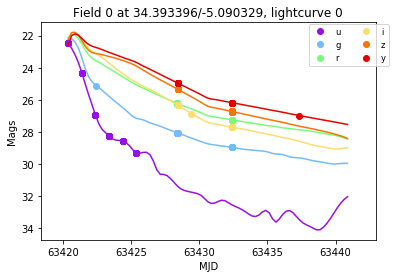

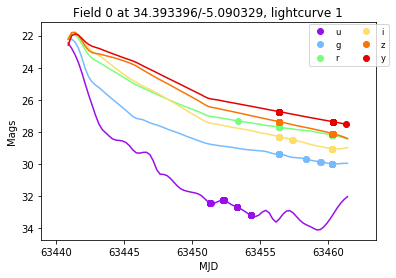

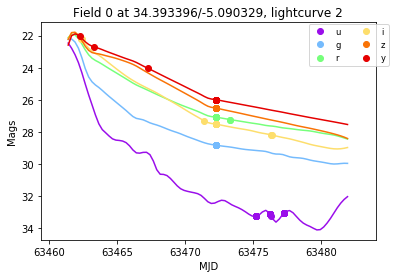

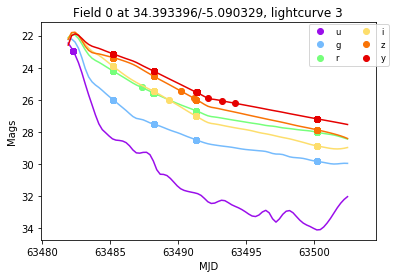

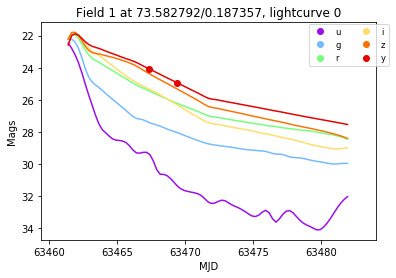

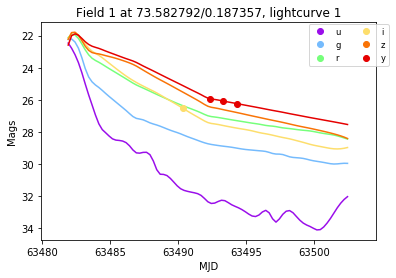

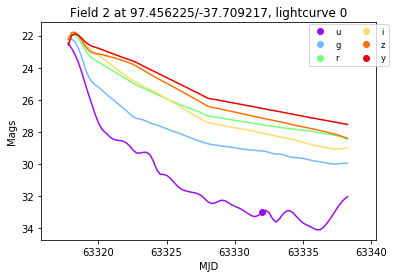

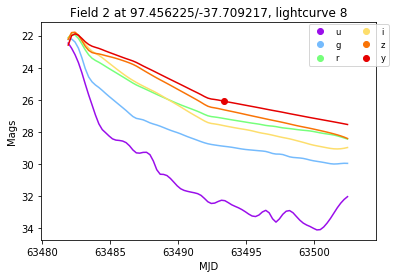

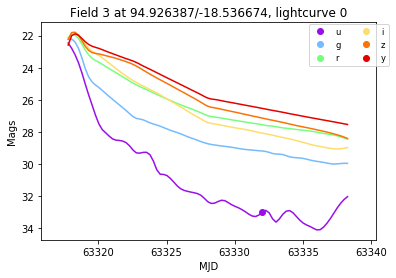

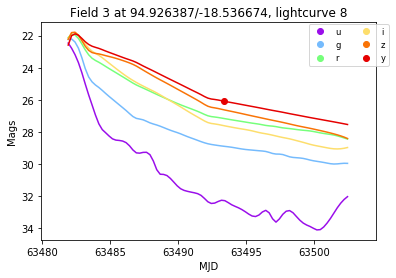

In [10]:
# Now plot both the full light curves from what we generated above, and the overlaid observations.
for i, data in enumerate(lightcurve_metric.metricValues):
    for lc_id in np.unique(data['transient_id']):
        match = np.where(data['transient_id'] == lc_id)
        plt.figure()
        epoch = data['epoch'][match]
        mjd = data['expMJD'][match]
        mags = data['lcMag'][match]
        filters = data['filter'][match]
        for f in filterNames:
            filtermatch = np.where(filters == f)
            plt.plot(times - epoch[0] + mjd[0], lc[f], color=colors[f])
            plt.plot(mjd[filtermatch], mags[filtermatch], 'o', color=colors[f], label=f)
        plt.ylim(plt.ylim()[::-1])
        plt.xlim(times[0] - epoch[0] + mjd[0] - 2, times[0] - epoch[0] + mjd[0]+transMetric.transient_duration*1.1)
        plt.legend(ncol = 2, loc = (.8,.8), numpoints=1, fontsize='smaller') 
        plt.xlabel('MJD')
        plt.ylabel('Mags')
        plt.title('Field %d at %f/%f, lightcurve %d' % (i, np.degrees(slicer.slicePoints['ra'][i]), 
                                                        np.degrees(slicer.slicePoints['dec'][i]), lc_id))
        plt.show()

## Now let's consider the metric over the full survey region and instead of looking at lightcurves look at the summary values

In [11]:
# Redefine the metric, again pass asciiSED explicitly though in prinicple
# it is defined as a default for GW170817. Also pass again mjdCol dependent on Opsim format.
metric = kNeMAF(asciiSED, mjdCol='observationStartMJD')

In [12]:
# Use the full sky healpixslicer
slicer = slicers.HealpixSlicer(nside=16)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [19]:
# Run for one year at the beginning of the survey (~2 minutes per survey year on laptop)
year = 0
dyear = 10
# Set SQL constraint as simply all nights within the specified years
sqlconstraint = 'night between %d and %d' % (365.25 * year, 365.25 * (year + dyear))

In [20]:
# We want to plot the results for visualization purposes
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
# From many previous runs we have found 0.01*dyear to usually be a good upperlimit.
# Of course, if you decrease the redshift the 0.01 multiplying factor should be increased.
plotDict = {'colorMin': 0, 'colorMax': 0.01*dyear}

In [21]:
# For summaries we would like the Median, Mean, and RMS error.
summaryMetrics = [metrics.MedianMetric(),metrics.MeanMetric(), metrics.RmsMetric()]
# Bundle the non-light-curve-ouput metric instance with our new slicers, sqlconstraint, plotting, and summary metric choices.
bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                    runName=runName, summaryMetrics=summaryMetrics,
                                    plotDict=plotDict, plotFuncs=plotFuncs)

# Again create overhead Bundle, though we only have one metric being run.
bundlegroup = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)

In [22]:
# Run the metric and time how long it takes
%time bundlegroup.runAll()

Querying database SummaryAllProps with constraint night between 0 and 3652 for columns ['filter', 'fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD']
Found 2438388 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 21min 35s, sys: 27.1 s, total: 22min 2s
Wall time: 22min 14s


Plotting figures with "night between 0 and 3652" constraint now.
Plotting complete.


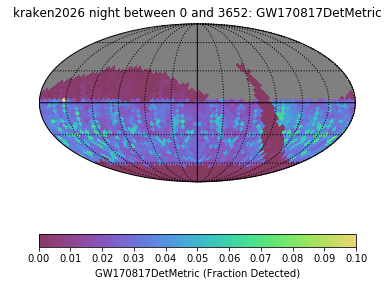

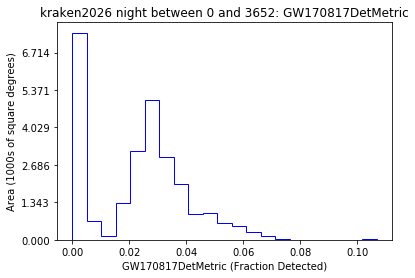

In [23]:
# Show our slicer healpix plot and histogram
bundlegroup.plotAll(closefigs=False)

In [24]:
# Output summary values
print (bundle.summaryValues)

{'Median': 0.025842696629213482, 'Mean': 0.02321096573784311, 'Rms': 0.017134215118683283}
